# CAPACITANCE RESISTANCE MODEL (CRM)

The Capacitance Resistance Model (CRM) is a widely used analytical tool in reservoir engineering for modeling fluid flow in porous media. It is a simplified representation of the complex physics of fluid flow in porous media, and is based on the principle of electrical circuit analogies.

In the CRM, the porous media is modeled as a network of interconnected blocks, each of which represents a small volume of the reservoir. The blocks are connected by conductive pathways, which represent the flow channels through which the fluid moves. The fluid flow is then modeled as a combination of two phenomena: capacitance and resistance.

Capacitance represents the storage of fluid in the porous media, and is analogous to the storage of electrical charge in a capacitor. Resistance represents the flow of fluid through the porous media, and is analogous to the flow of current through a resistor.

The CRM equations are used to model the flow of fluid in the reservoir, and to calculate important parameters such as reservoir pressure, production rate, and recovery factor. The model is particularly useful in predicting the behavior of water and gas injection wells, and in optimizing production strategies.

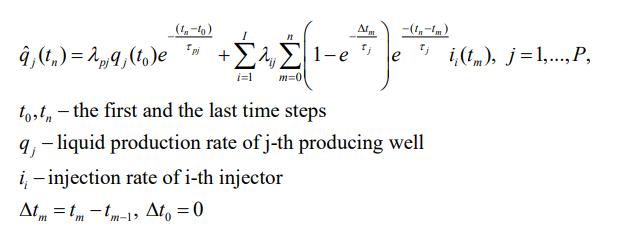

In [42]:
# Import the necessary libraries

import numpy as np
import random
import pandas as pd

In [43]:
import matplotlib.pyplot as plt
from scipy.optimize import minimize

## TASK 1

Divide the given dataset on training and testing sets (try at least three different ratios), then 
tune the model parameters (using existing optimization packages or your own 
optimization scheme) on the training set and make forecasts for the testing set. Plot the
results.

In [44]:
data = pd.read_excel('data.xlsx', 'Sheet1')

In [45]:
data.head()

,Date,I01,P01,P02,P03,P04
0,2005-12-31,0,0.000000,0.000000,0.000000,0.000000
1,2006-01-30,100,148.929253,148.929282,148.929382,148.929306
2,2006-03-01,100,91.320024,91.319542,91.319315,91.319354
3,2006-03-31,100,64.925984,64.925856,64.925761,64.925798
4,2006-04-30,100,48.562603,48.562865,48.562994,48.562919


In [46]:
production_rates = data.iloc[:, 2:]
injection_rates = data.iloc[:, 1:2]

In [47]:
production_rates.shape, injection_rates.shape

((81, 4), (81, 1))

In [48]:
dt = pd.to_datetime(data.iloc[:, 0])
days = [0]
for i in range(len(dt)-1):
    days.append(days[i] + (dt.iloc[i+1] - dt.iloc[i]).days / 30)
dt_cum = pd.Series(days, name='Date')

In [49]:
dt_cum.shape

(81,)

In [62]:
# Populate the model function using CRMP representation


def prime_term(lambda_pj, tay_pj, production_rates, t_n, t_n0):
    
    prime_term = lambda_pj * production_rates * np.exp(-(t_n - t_n0) / tay_pj)
    
    return prime_term

#Injection Well

def conv_inj(lambda_weights, tay_j, injection_rates, dt_cum):
    
    conv_inj = 0
    
    for k in range(injection_rates.shape[1]):
        
        injection = 0
        n = injection_rates.shape[0]
        
        for l in range(n):
            if l == 0:
                d_t_l = 0
            else:
                d_t_l = dt_cum[l] - dt_cum[l-1]
            injection = injection + ((1 - np.exp(-(d_t_l) / tay_j[k])) * np.exp(-(dt_cum[n - 1] - dt_cum[l]) / tay_j[k]) * injection_rates[l])[-1]
        injection = injection * lambda_weights[k]
        conv_inj = conv_inj + injection
        
    return conv_inj

#Summary

def q(lambda_weights, tay_j, production_rates, injection_rates, dt_cum):
    
    ans = np.zeros_like(production_rates)
    
    for i in range(production_rates.shape[1]):
        for n in range(production_rates.shape[0]):
            ans[n, i] = ans[n, i] + prime_term(lambda_weights[0, i], tay_j[0, i], production_rates[0, i], dt_cum[n], dt_cum[0])
            ans[n, i] = ans[n, i] + conv_inj(lambda_weights[1:, i], tay_j[1:, i], injection_rates[:n + 1], dt_cum[:n + 1])
    
    return ans




In [51]:
class model():
    
    def unknown(self):
        return self.lambda_weights, self.tay_j

    def compare(self, production_rates, injection_rates, dt_cum):

# Write down the initial guess for params

        self.lambda_weights = np.ones((injection_rates.shape[1] + 1, production_rates.shape[1])) * 0.25
        self.lambda_weights[0] = np.ones(production_rates.shape[1])
        self.tay_j = np.ones((injection_rates.shape[1] + 1, production_rates.shape[1])) * 1

        if isinstance(production_rates, pd.DataFrame) or isinstance(production_rates, pd.Series):
            self.production_rates = production_rates.to_numpy()
        else:
            self.production_rates = production_rates

        if isinstance(injection_rates, pd.DataFrame) or isinstance(injection_rates, pd.Series):
            self.injection_rates = injection_rates.to_numpy()
        else:
            self.injection_rates = injection_rates

        if isinstance(dt_cum, pd.DataFrame) or isinstance(dt_cum, pd.Series):
            self.dt_cum = dt_cum.to_numpy()
        else:
            self.dt_cum = dt_cum

        self.optimization()

    def param(self, x, production_rates, injection_rates, dt_cum):

        old_x = np.reshape(x, (4, 4))
        lambda_weights = old_x[:(injection_rates.shape[1] + 1)]
        tay_j = old_x[(injection_rates.shape[1] + 1):]
        q_r = q(lambda_weights, tay_j, production_rates, injection_rates, dt_cum)
        ans = np.sum(np.power(production_rates - q_r, 2)) / production_rates.shape[0]
        return ans

    def optimization(self):
        
        def constraint(x):
            
            old_x = np.reshape(x, (4, 4))
            lambda_weights = old_x[1]
            summary = 1
            summary = summary - np.sum(lambda_weights)
            return summary

        con1 = {'type': 'eq', 'fun': constraint}
        x0 = np.concatenate([self.lambda_weights, self.tay_j])
        sol = minimize(self.param, x0, args=(self.production_rates, self.injection_rates, self.dt_cum), constraints=con1, options={'maxiter': 10e6, 'disp': True})
        opt_x = np.reshape(sol.x, (4, 4))
        self.lambda_weights = opt_x[:2]
        self.tay_j = opt_x[2:]

    def prediction(self, production_rates, injection_rates, dt_cum):
        
        if isinstance(production_rates, pd.DataFrame) or isinstance(production_rates, pd.Series):
            production_rates = production_rates.to_numpy()
        else:
            production_rates = production_rates

        if isinstance(injection_rates, pd.DataFrame) or isinstance(injection_rates, pd.Series):
            injection_rates = injection_rates.to_numpy()
        else:
            injection_rates = injection_rates

        if isinstance(dt_cum, pd.DataFrame) or isinstance(dt_cum, pd.Series):
            dt_cum = dt_cum.to_numpy()
        else:
            dt_cum = dt_cum

        return q(self.lambda_weights, self.tay_j, production_rates, injection_rates, dt_cum)

In [52]:
#Predict on the train and test values with optimization scheme

def Test(testing_set, n):
    trainig_set = production_rates.shape[0] - testing_set
    clf = model()
    clf.compare(production_rates.iloc[1:trainig_set], injection_rates.iloc[1:trainig_set], dt_cum.iloc[1:trainig_set])
    ans = pd.DataFrame(clf.prediction(production_rates.iloc[trainig_set:], injection_rates.iloc[trainig_set:], dt_cum.iloc[trainig_set:]))
    l, t = clf.unknown()

    qpred1 = ans.iloc[:, 0].to_numpy()
    np.set_printoptions(precision=6,suppress=True)
    qi = clf.prediction(production_rates.iloc[1:] , injection_rates.iloc[1:], dt_cum.iloc[1:])

    return qpred1, qi, ans, l

C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\1966676502.py:52: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  sol = minimize(self.param, x0, args=(self.production_rates, self.injection_rates, self.dt_cum), constraints=con1, options={'maxiter': 10e6, 'disp': True})


Optimization terminated successfully    (Exit mode 0)
            Current function value: 222.08309966571215
            Iterations: 21
            Function evaluations: 402
            Gradient evaluations: 21


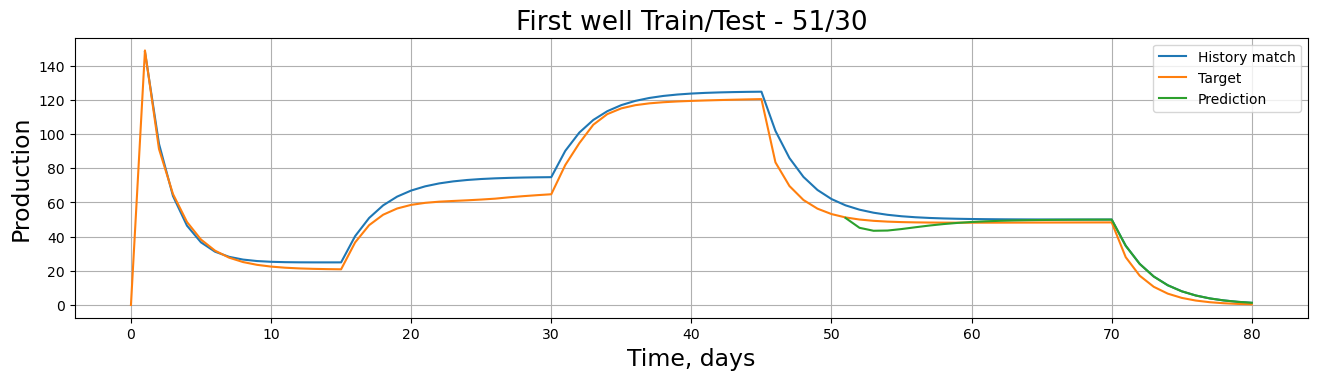

In [53]:
Test_1 = Test(30, 0)

plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('First well Train/Test - 51/30', fontsize = 19)
plt.plot(range(1, 81, 1), Test_1[1][:,:1].flatten(), label = 'History match')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 0:1].to_numpy().flatten(), label = 'Target')
plt.plot(range(51, 81, 1), Test_1[0], label = 'Prediction')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()

C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\1966676502.py:52: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  sol = minimize(self.param, x0, args=(self.production_rates, self.injection_rates, self.dt_cum), constraints=con1, options={'maxiter': 10e6, 'disp': True})
C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\2033671024.py:6: RuntimeWarning: overflow encountered in exp
  prime_term = lambda_pj * production_rates * np.exp(-(t_n - t_n0) / tay_pj)
C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\1966676502.py:37: RuntimeWarning: overflow encountered in power
  ans = np.sum(np.power(production_rates - q_r, 2)) / production_rates.shape[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 194.46860206068146
            Iterations: 21
            Function evaluations: 404
            Gradient evaluations: 21


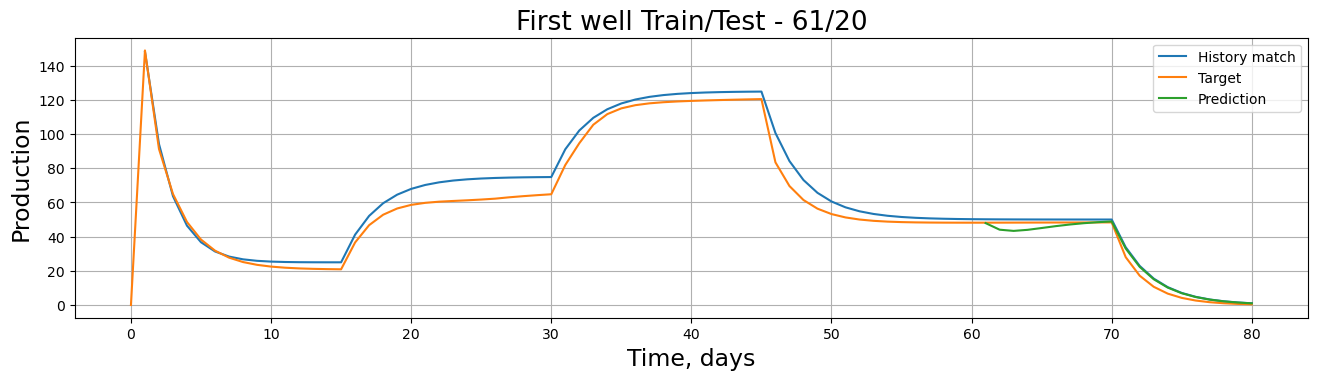

In [54]:
Test_2 = Test(20, 0)

plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('First well Train/Test - 61/20', fontsize = 19)
plt.plot(range(1, 81, 1), Test_2[1][:,:1].flatten(), label = 'History match')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 0:1].to_numpy().flatten(), label = 'Target')
plt.plot(range(61, 81, 1), Test_2[0], label = 'Prediction')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()




C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\1966676502.py:52: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  sol = minimize(self.param, x0, args=(self.production_rates, self.injection_rates, self.dt_cum), constraints=con1, options={'maxiter': 10e6, 'disp': True})
C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\2033671024.py:6: RuntimeWarning: overflow encountered in exp
  prime_term = lambda_pj * production_rates * np.exp(-(t_n - t_n0) / tay_pj)
C:\Users\Nathan.Ehimen\AppData\Local\Temp\ipykernel_18476\1966676502.py:37: RuntimeWarning: overflow encountered in power
  ans = np.sum(np.power(production_rates - q_r, 2)) / production_rates.shape[0]


Optimization terminated successfully    (Exit mode 0)
            Current function value: 168.5406889646274
            Iterations: 19
            Function evaluations: 369
            Gradient evaluations: 19


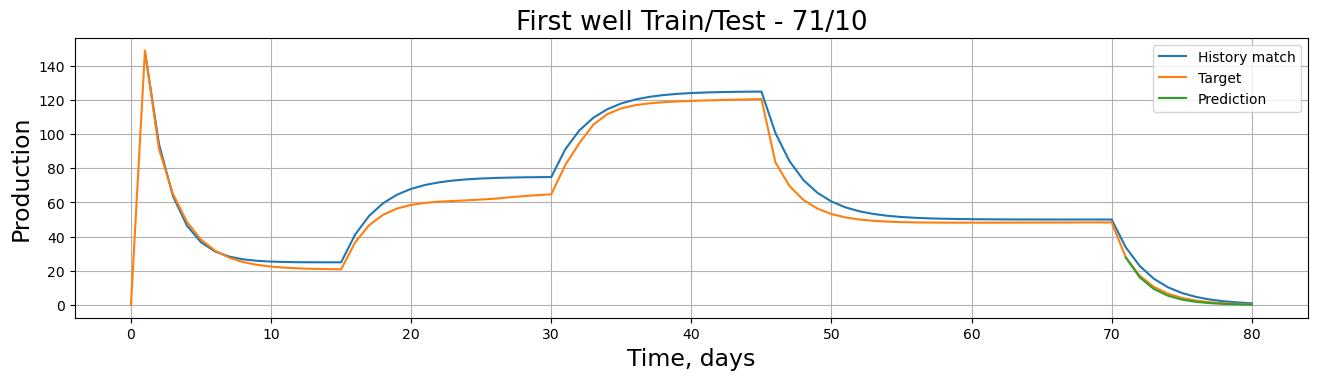

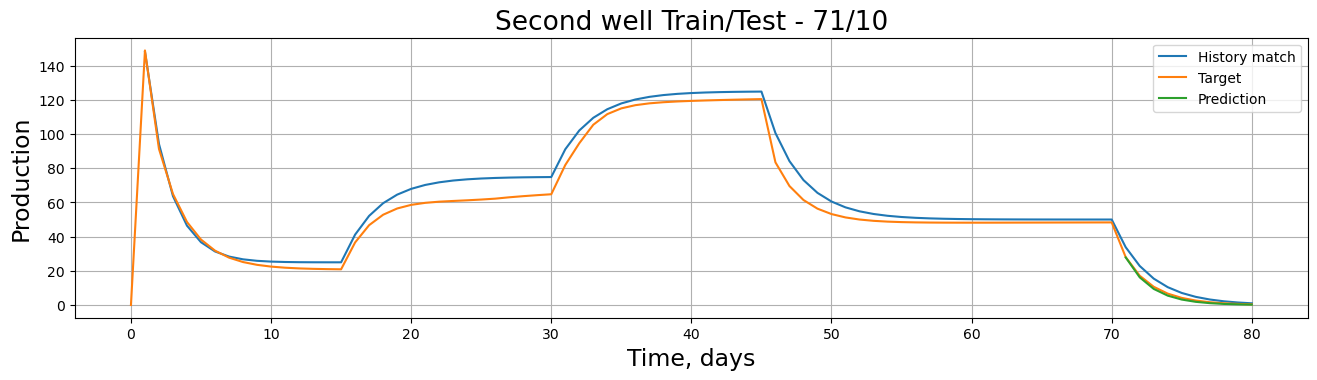

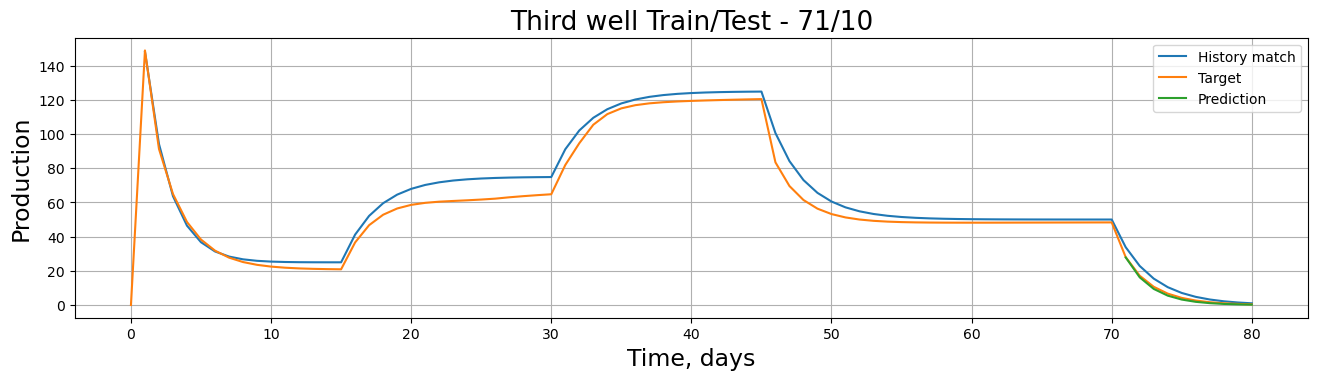

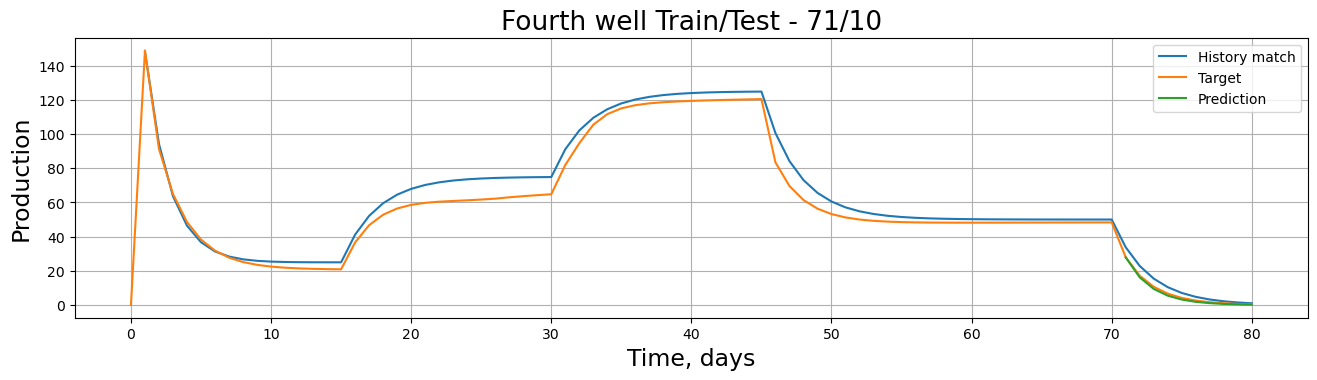

In [55]:
Test_3 = Test(10, 0)

plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('First well Train/Test - 71/10', fontsize = 19)
plt.plot(range(1, 81, 1), Test_3[1][:,:1].flatten(), label = 'History match')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 0:1].to_numpy().flatten(), label = 'Target')
plt.plot(range(71, 81, 1), Test_3[0], label = 'Prediction')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()

plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('Second well Train/Test - 71/10', fontsize = 19)
plt.plot(range(1, 81, 1), Test_3[1][:,1:2].flatten(), label = 'History match')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 1:2].to_numpy().flatten(), label = 'Target')
plt.plot(range(71, 81, 1), Test_3[0], label = 'Prediction')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()

plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('Third well Train/Test - 71/10', fontsize = 19)
plt.plot(range(1, 81, 1), Test_3[1][:,2:3].flatten(), label = 'History match')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 2:3].to_numpy().flatten(), label = 'Target')
plt.plot(range(71, 81, 1), Test_3[0], label = 'Prediction')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()

plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('Fourth well Train/Test - 71/10', fontsize = 19)
plt.plot(range(1, 81, 1), Test_3[1][:,3:4].flatten(), label = 'History match')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 3:4].to_numpy().flatten(), label = 'Target')
plt.plot(range(71, 81, 1), Test_3[0], label = 'Prediction')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()

To save space, the test plots of the second third and fourth wells are plotted only for the most accurate test.

## TASK 2

Calculate metrics (MAE, MSE, R2
) on the full dataset and compare the results depending 
on the ratio division during optimization procedure. Make sure that the sum of defined 
lambda coefficients for each injector (you have only one in this case) is equal to one. If 
not, use constraint optimization.

In [56]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [57]:
MSE = mean_squared_error(production_rates.iloc[51:], Test_1[2])
MAE = mean_absolute_error(production_rates.iloc[51:], Test_1[2])
R2 = r2_score(production_rates.iloc[51:], Test_1[2])

print('Metrics for Test 1:')
print(f'MSE = {round(MSE,2)}')
print(f'MAE = {round(MAE,2)}')
print(f'R2 = {round(R2,2)}')

Metrics for Test 1:
MSE = 10.64
MAE = 2.58
R2 = 0.97


In [58]:
MSE = mean_squared_error(production_rates.iloc[61:], Test_2[2])
MAE = mean_absolute_error(production_rates.iloc[61:], Test_2[2])
R2 = r2_score(production_rates.iloc[61:], Test_2[2])

print('Metrics for Test 2:')
print(f'MSE = {round(MSE,2)}')
print(f'MAE = {round(MAE,2)}')
print(f'R2 = {round(R2,2)}')

Metrics for Test 2:
MSE = 8.76
MAE = 2.4
R2 = 0.98


In [59]:
MSE = mean_squared_error(production_rates.iloc[71:], Test_3[2])
MAE = mean_absolute_error(production_rates.iloc[71:], Test_3[2])
R2 = r2_score(production_rates.iloc[71:], Test_3[2])

print('Metrics for Test 3:')
print(f'MSE = {round(MSE,2)}')
print(f'MAE = {round(MAE,2)}')
print(f'R2 = {round(R2,2)}')

Metrics for Test 3:
MSE = 0.59
MAE = 0.66
R2 = 0.99


In [63]:
#Check that sum of defined lambda coefficients is equal to one

if round(np.sum(Test_3[3][1]),6) == 1:
    print('The sum of defined lambda coefficients for each injector is equal to one therefore material balance check is successful.')

The sum of defined lambda coefficients for each injector is equal to one therefore material balance check is successful.


Apparently, due to a commensurately small amount of data, a small set of the training model predetermines a high error in the predicted behavior of the production rate. In this case, the best fit for all wells is the last test performed on the 71/10 data set with the minimum error metrics.

### Task 3: 

Capacitance Resistance Model based on the two main values - primary and injection which are correspon the weight on the rate at previous time and the weight on the injection signals at current time respectively. This history match method is a powerfell and usefull technique, wich stated on a hypothesis that characteristics of a reservoir can be indeffed from analyzing production and injection data only. On the diagram below one important fact is shown - production strongly response to an injection signal (even if there is only one pumping well among others).

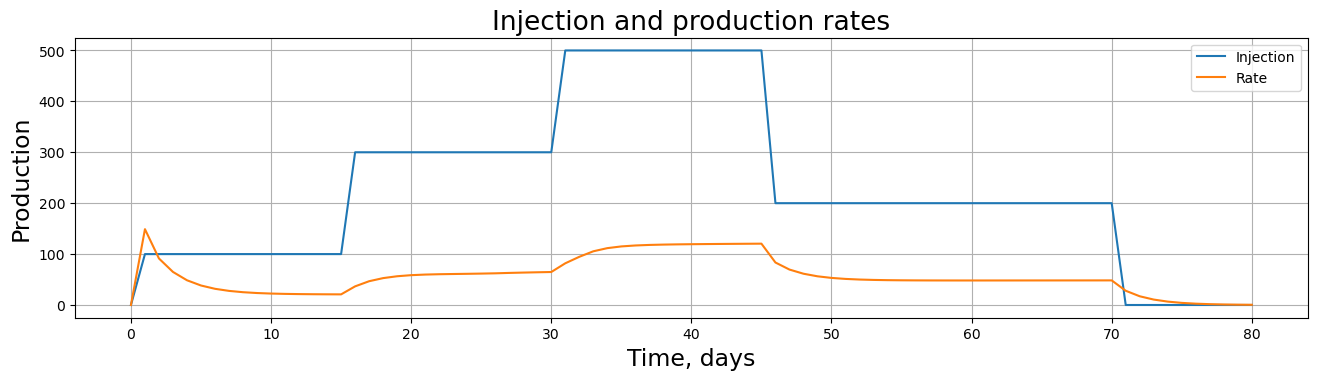

In [61]:
plt.figure(figsize = (35,8))
plt.subplot(221)
plt.title('Injection and production rates', fontsize = 19)
plt.plot(range(0, 81, 1), injection_rates, label = 'Injection')
plt.plot(range(0, 81, 1), production_rates.iloc[:, 0:1].to_numpy().flatten(), label = 'Rate')

plt.xlabel('Time, days', fontsize = 17)
plt.ylabel('Production', fontsize = 17)
plt.legend()
plt.grid()

In conclusion, according to Prof.Larry W. Lake, connectivity or gain (lambda) is responsible for communication between well pairs, and the time constant (tau) is the ratio of the compressible pore volume to the productivity index (PI or J) each producer. As shown by the most accurate test, the "material balance check" is conclusive and the gain is approximately equal to 0.25, which is the minimum value. Finally, as seen in the plot above, the relationship between the production and injection wells is somewhat "positive/acceptable" and it is likely that the reservoir is homogeneous and there are highly permeable channels in the interwell space.

## REFERENCES

(1) https://repositories.lib.utexas.edu/bitstream/handle/2152/ETD-UT-2012-08-6143/NGUYEN-DISSERTATION.pdf?sequence=1&isAllowed=y

(2) Professor Larry W. Lake- https://www.youtube.com/watch?v=rGD5dj7Y1vg&pp=ygUqY2FwYWNpdGFuY2UgcmVzaXN0YW5jZSBtb2RlbCBpbiB3YXRlcmZsb29k

(3) https://www.youtube.com/watch?v=JttI8zbB6N8&pp=ygUqY2FwYWNpdGFuY2UgcmVzaXN0YW5jZSBtb2RlbCBpbiB3YXRlcmZsb29k